## Install MMOCR

When installing dependencies for mmocr, please ensure that all the dependency versions are compatible with each other. For instance, if CUDA 10.1 is installed, then the Pytorch version must be compatible with cu10.1. Please see [getting_started.md](docs/getting_started.md) for more details. 

In [1]:
%cd ..

/


### Check PyTorch version

In [2]:
!pip show torch


Name: torch
Version: 1.12.0+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


### Install Dependencies 

In [3]:
import torch
import torchaudio
import sys
print("User Current Version:-", sys.version)
print(torch.__version__)
print(torchaudio.__version__)

User Current Version:- 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
1.12.0+cu113
0.12.0+cu113


In [4]:
# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 3.6 MB/s 
     |████████████████████████████████| 190 kB 8.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.6 MB/s 
Cloning into 'mmocr'...
remote: Enumerating objects: 6784, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 6784 (delta 10), reused 20 (delta 4), pack-reused 6743
Receiving objects: 100% (6784/6784), 13.21 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (4236/4236), done.
/mmocr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 604 kB 7.6 MB/s 
  Installing build dependencies ... done

### Check Installed Dependencies Versions

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /mmocr/
!ls

1.12.0+cu113 True
2.25.0
1.6.0
11.3
GCC 9.3
0.6.0
/mmocr
CITATION.cff  docs	   mmocr.egg-info   requirements      setup.py
configs       LICENSE	   model-index.yml  requirements.txt  tests
demo	      MANIFEST.in  README.md	    resources	      tools
docker	      mmocr	   README_zh-CN.md  setup.cfg


### Note: check working dir path carefully!

In [6]:
pwd

'/mmocr'

### Create mmocr custom class

In [7]:
from mmocr.utils.ocr import MMOCR
import os
import matplotlib.pyplot as plt
import json
from google.colab.patches import cv2_imshow
import cv2

class MMOCR_Custom:
  def __init__(self, image_path, output_folder, export_json_folder):
    self.image_path = image_path
    self.filename = os.path.splitext(os.path.basename(image_path))[0]
    if(output_folder[-1]!="/"):
      self.output_file_path = output_folder+"/"+self.filename+'_pred.jpg'
    else:
      self.output_file_path = output_folder+self.filename+'_pred.jpg'

    if(export_json_folder[-1]!="/"):
      self.export_json_folder = export_json_folder+"/"
    else:
      self.export_json_folder = export_json_folder
    self.export_json_path = export_json_folder+'/out_'+self.filename+'.json'
    self._isRun = 0
    self.__run()
  def load_json_file_helper(self, path):
    # Opening JSON file
    f = open(path)
      
    # returns JSON object as 
    # a dictionary
    json_obj = json.load(f)
    return json_obj

 


  def crop_helper(self,img, box_coordinate, save_path):
    # coordinate in mmocr format (x,y)
    x_list = []
    y_list = []
    for i in range (0,len(box_coordinate),2):
      x_list.append(box_coordinate[i])
      y_list.append(box_coordinate[i+1])
    x_max = max(x_list)
    x_min = min(x_list)
    y_max = max(y_list)
    y_min = min(y_list)
    # opencv format (y,x)
    crop_img = img[y_min:y_max, x_min:x_max]
    cv2.imwrite(save_path, crop_img)
    cv2_imshow(crop_img)

    return crop_img
  def __run(self):
    ocr = MMOCR()
    self.json_result = ocr.readtext(self.image_path, output = self.output_file_path, print_result=False, details=True, imshow=False, export= self.export_json_folder)

  def visualize_result(self):
    predicted_img = mmcv.imread(self.output_file_path)
    plt.imshow(mmcv.bgr2rgb(predicted_img))
    plt.show()
    
  def bounding_boxes(self):
    data = self.load_json_file_helper(self.export_json_path)
    boxes_info = data["result"]
    return boxes_info
  def bounding_boxes_coordinates(self):
    boxes= self.bounding_boxes()
    boxes_coordinates = [box["box"] for box in boxes]
    return boxes_coordinates
  def visualize_cropped_result(self, cropped_result_folder): 
    print("Cropped results saved at:",cropped_result_folder)
    print("RESULTS:")

    boxes_info = self.bounding_boxes()

    data = self.load_json_file_helper(self.export_json_path)
    boxes_info = data["result"]
    i = 1
    for box_info in boxes_info:
      print(box_info)
      box = box_info["box"]
      test_img = cv2.imread(self.image_path)
      print(cropped_result_folder+box_info["text"]+".jpg")
      self.crop_helper(test_img, box, cropped_result_folder+box_info["text"]+".jpg")
      print("--------------------//----------------------")


In [8]:
my_mmocr = MMOCR_Custom(image_path = "/mmocr/demo/demo_text_det.jpg",
                        output_folder = "/mmocr/outputs/images/",
                        export_json_folder = '/mmocr/outputs/json_outputs/')

load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/panet/panet_r18_fpem_ffm_sbn_600e_icdar2015_20210219-42dbe46a.pth


Downloading: "https://download.openmmlab.com/mmocr/textdet/panet/panet_r18_fpem_ffm_sbn_600e_icdar2015_20210219-42dbe46a.pth" to /root/.cache/torch/hub/checkpoints/panet_r18_fpem_ffm_sbn_600e_icdar2015_20210219-42dbe46a.pth


  0%|          | 0.00/44.0M [00:00<?, ?B/s]

load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth


Downloading: "https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth" to /root/.cache/torch/hub/checkpoints/seg_r31_1by16_fpnocr_academic-72235b11.pth


  0%|          | 0.00/182M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


### Visualize the result

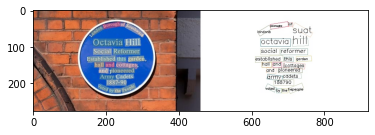

In [9]:
my_mmocr.visualize_result()

### Get JSON result

In [10]:
print(my_mmocr.json_result)

[{'filename': 'demo_text_det', 'result': [{'box': [191, 39, 239, 31, 241, 44, 193, 52], 'box_score': 0.9748765230178833, 'text': 'aborougho', 'text_score': 0.9753086419753088}, {'box': [240, 34, 253, 34, 253, 45, 240, 45], 'box_score': 0.9292463660240173, 'text': 'iof', 'text_score': 1.3333333333333333}, {'box': [252, 47, 259, 34, 308, 62, 301, 74], 'box_score': 0.9515694379806519, 'text': 'suat', 'text_score': 0.9583333333333334}, {'box': [156, 60, 188, 41, 194, 52, 163, 71], 'box_score': 0.954505980014801, 'text': 'londonb', 'text_score': 1.0}, {'box': [251, 79, 294, 76, 296, 97, 252, 99], 'box_score': 0.9551578164100647, 'text': 'hill', 'text_score': 1.0}, {'box': [165, 78, 247, 78, 247, 99, 165, 99], 'box_score': 0.9459986686706543, 'text': 'octavia', 'text_score': 1.0}, {'box': [165, 105, 216, 105, 216, 122, 165, 122], 'box_score': 0.9782547354698181, 'text': 'social', 'text_score': 1.0}, {'box': [220, 105, 294, 105, 294, 122, 220, 122], 'box_score': 0.9601640701293945, 'text': 'r

### Get bounding boxes list

In [11]:
boxes = my_mmocr.bounding_boxes()
print("Bounding box details:")
for box in boxes:
  print(box)

Bounding box details:
{'box': [191, 39, 239, 31, 241, 44, 193, 52], 'box_score': 0.9748765230178833, 'text': 'aborougho', 'text_score': 0.9753086419753088}
{'box': [240, 34, 253, 34, 253, 45, 240, 45], 'box_score': 0.9292463660240173, 'text': 'iof', 'text_score': 1.3333333333333333}
{'box': [252, 47, 259, 34, 308, 62, 301, 74], 'box_score': 0.9515694379806519, 'text': 'suat', 'text_score': 0.9583333333333334}
{'box': [156, 60, 188, 41, 194, 52, 163, 71], 'box_score': 0.954505980014801, 'text': 'londonb', 'text_score': 1.0}
{'box': [251, 79, 294, 76, 296, 97, 252, 99], 'box_score': 0.9551578164100647, 'text': 'hill', 'text_score': 1.0}
{'box': [165, 78, 247, 78, 247, 99, 165, 99], 'box_score': 0.9459986686706543, 'text': 'octavia', 'text_score': 1.0}
{'box': [165, 105, 216, 105, 216, 122, 165, 122], 'box_score': 0.9782547354698181, 'text': 'social', 'text_score': 1.0}
{'box': [220, 105, 294, 105, 294, 122, 220, 122], 'box_score': 0.9601640701293945, 'text': 'reformer', 'text_score': 1.0

### Get bounding boxes's coordinates

In [12]:
boxes_coordinates = my_mmocr.bounding_boxes_coordinates()
print("4 corner coordinates:")
for box_corners in boxes_coordinates:
  print(box_corners)

4 corner coordinates:
[191, 39, 239, 31, 241, 44, 193, 52]
[240, 34, 253, 34, 253, 45, 240, 45]
[252, 47, 259, 34, 308, 62, 301, 74]
[156, 60, 188, 41, 194, 52, 163, 71]
[251, 79, 294, 76, 296, 97, 252, 99]
[165, 78, 247, 78, 247, 99, 165, 99]
[165, 105, 216, 105, 216, 122, 165, 122]
[220, 105, 294, 105, 294, 122, 220, 122]
[150, 127, 226, 124, 227, 140, 150, 143]
[229, 128, 255, 128, 255, 141, 229, 141]
[262, 127, 304, 125, 305, 139, 262, 141]
[168, 142, 195, 142, 195, 156, 168, 156]
[198, 142, 223, 142, 223, 156, 198, 156]
[227, 156, 229, 141, 287, 147, 285, 161]
[180, 171, 181, 157, 208, 159, 207, 173]
[213, 158, 279, 158, 279, 171, 213, 171]
[226, 177, 276, 174, 277, 186, 227, 189]
[182, 188, 184, 175, 225, 180, 223, 193]
[201, 190, 256, 190, 256, 206, 201, 206]
[178, 213, 184, 201, 208, 212, 203, 224]
[240, 214, 278, 199, 283, 213, 246, 228]
[208, 214, 222, 214, 222, 226, 208, 226]
[223, 214, 240, 214, 240, 226, 223, 226]


### Atterntion: We have to make dir first before we save cropped image
### In this case, I saved all crop images in:
/mmocr/outputs/crop_images

Cropped results saved at: /mmocr/outputs/crop_images/
RESULTS:
{'box': [191, 39, 239, 31, 241, 44, 193, 52], 'box_score': 0.9748765230178833, 'text': 'aborougho', 'text_score': 0.9753086419753088}
/mmocr/outputs/crop_images/aborougho.jpg


--------------------//----------------------
{'box': [240, 34, 253, 34, 253, 45, 240, 45], 'box_score': 0.9292463660240173, 'text': 'iof', 'text_score': 1.3333333333333333}
/mmocr/outputs/crop_images/iof.jpg


--------------------//----------------------
{'box': [252, 47, 259, 34, 308, 62, 301, 74], 'box_score': 0.9515694379806519, 'text': 'suat', 'text_score': 0.9583333333333334}
/mmocr/outputs/crop_images/suat.jpg


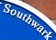

--------------------//----------------------
{'box': [156, 60, 188, 41, 194, 52, 163, 71], 'box_score': 0.954505980014801, 'text': 'londonb', 'text_score': 1.0}
/mmocr/outputs/crop_images/londonb.jpg


--------------------//----------------------
{'box': [251, 79, 294, 76, 296, 97, 252, 99], 'box_score': 0.9551578164100647, 'text': 'hill', 'text_score': 1.0}
/mmocr/outputs/crop_images/hill.jpg


--------------------//----------------------
{'box': [165, 78, 247, 78, 247, 99, 165, 99], 'box_score': 0.9459986686706543, 'text': 'octavia', 'text_score': 1.0}
/mmocr/outputs/crop_images/octavia.jpg


--------------------//----------------------
{'box': [165, 105, 216, 105, 216, 122, 165, 122], 'box_score': 0.9782547354698181, 'text': 'social', 'text_score': 1.0}
/mmocr/outputs/crop_images/social.jpg


--------------------//----------------------
{'box': [220, 105, 294, 105, 294, 122, 220, 122], 'box_score': 0.9601640701293945, 'text': 'reformer', 'text_score': 1.0}
/mmocr/outputs/crop_images/reformer.jpg


--------------------//----------------------
{'box': [150, 127, 226, 124, 227, 140, 150, 143], 'box_score': 0.9731660485267639, 'text': 'established', 'text_score': 1.0}
/mmocr/outputs/crop_images/established.jpg


--------------------//----------------------
{'box': [229, 128, 255, 128, 255, 141, 229, 141], 'box_score': 0.9750726819038391, 'text': 'this', 'text_score': 1.0}
/mmocr/outputs/crop_images/this.jpg


--------------------//----------------------
{'box': [262, 127, 304, 125, 305, 139, 262, 141], 'box_score': 0.9677677750587463, 'text': 'garden', 'text_score': 1.1666666666666667}
/mmocr/outputs/crop_images/garden.jpg


--------------------//----------------------
{'box': [168, 142, 195, 142, 195, 156, 168, 156], 'box_score': 0.9712427854537964, 'text': 'hall', 'text_score': 1.0}
/mmocr/outputs/crop_images/hall.jpg


--------------------//----------------------
{'box': [198, 142, 223, 142, 223, 156, 198, 156], 'box_score': 0.9310973286628723, 'text': 'and', 'text_score': 1.0}
/mmocr/outputs/crop_images/and.jpg


--------------------//----------------------
{'box': [227, 156, 229, 141, 287, 147, 285, 161], 'box_score': 0.9559815526008606, 'text': 'jcottages', 'text_score': 1.0666666666666667}
/mmocr/outputs/crop_images/jcottages.jpg


--------------------//----------------------
{'box': [180, 171, 181, 157, 208, 159, 207, 173], 'box_score': 0.9579461216926575, 'text': 'and', 'text_score': 1.0}
/mmocr/outputs/crop_images/and.jpg


--------------------//----------------------
{'box': [213, 158, 279, 158, 279, 171, 213, 171], 'box_score': 0.9789628982543945, 'text': 'pioneered', 'text_score': 1.0}
/mmocr/outputs/crop_images/pioneered.jpg


--------------------//----------------------
{'box': [226, 177, 276, 174, 277, 186, 227, 189], 'box_score': 0.9821320176124573, 'text': 'cadets', 'text_score': 1.0}
/mmocr/outputs/crop_images/cadets.jpg


--------------------//----------------------
{'box': [182, 188, 184, 175, 225, 180, 223, 193], 'box_score': 0.9740584492683411, 'text': 'army', 'text_score': 1.25}
/mmocr/outputs/crop_images/army.jpg


--------------------//----------------------
{'box': [201, 190, 256, 190, 256, 206, 201, 206], 'box_score': 0.9747076630592346, 'text': '188790', 'text_score': 1.1666666666666667}
/mmocr/outputs/crop_images/188790.jpg


--------------------//----------------------
{'box': [178, 213, 184, 201, 208, 212, 203, 224], 'box_score': 0.9763814210891724, 'text': 'voted', 'text_score': 1.0}
/mmocr/outputs/crop_images/voted.jpg


--------------------//----------------------
{'box': [240, 214, 278, 199, 283, 213, 246, 228], 'box_score': 0.9473305940628052, 'text': 'hepeople', 'text_score': 1.0}
/mmocr/outputs/crop_images/hepeople.jpg


--------------------//----------------------
{'box': [208, 214, 222, 214, 222, 226, 208, 226], 'box_score': 0.9591458439826965, 'text': 'by', 'text_score': 1.0}
/mmocr/outputs/crop_images/by.jpg


--------------------//----------------------
{'box': [223, 214, 240, 214, 240, 226, 223, 226], 'box_score': 0.9572067260742188, 'text': 'the', 'text_score': 1.0}
/mmocr/outputs/crop_images/the.jpg


--------------------//----------------------


In [13]:
!mkdir /mmocr/outputs/crop_images
my_mmocr.visualize_cropped_result(cropped_result_folder='/mmocr/outputs/crop_images/')